## Implement a CNN architecture for FashionMNIST dataset
The FashionMNIST dataset implemented by different Deep Learning architectures

1.   A basic CNN architecture
2.   ResNet module
3.   Inception Module

  


## Install and Import Packages

In [0]:
!pip install sklearn
!pip install pandas
!pip install numpy
!pip install --upgrade tensorflow
!pip install --upgrade keras

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc3)
Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.3.1)


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from keras.datasets import fashion_mnist
from keras.datasets import mnist

import tensorflow.keras
from tensorflow.keras.layers import Dense,Conv2D, Input, Flatten, BatchNormalization, Activation,MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

from keras.layers import Dense as keras_Dense
from keras.layers import Conv2D as keras_Conv2D
from keras.layers import MaxPooling2D as keras_MaxPooling2D
from keras.layers import Flatten as keras_Flatten

from keras import regularizers
from keras import optimizers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential


Using TensorFlow backend.


In [0]:
def show_image (X):
  fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(10, 5), subplot_kw={'xticks': [], 'yticks': []})
  for ax, i in zip(axs.flat, range(10)):
    ax.imshow(X[i], interpolation='spline16', cmap='gray')
  plt.show()

In [0]:
def plot_accuracy(history):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
  axs[0].plot(history.history['accuracy'], label='Train Accuracy')
  axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
  #plt.yticks(np.arange(0.7, 1., step=0.05))
  axs[0].legend()
  axs[0].set_title('Accuracy')

  axs[1].plot(history.history['loss'], label='Train Loss')
  axs[1].plot(history.history['val_loss'], label='Validation Loss')
  axs[1].legend()
  axs[1].set_title('Loss')
  plt.show()

### Read dataset and preprocessing the data

4423680/4422102 [==============================] - 0s 0us/step
Shape of the data :  (60000, 28, 28) (10000, 28, 28)
plot 10 sample of data


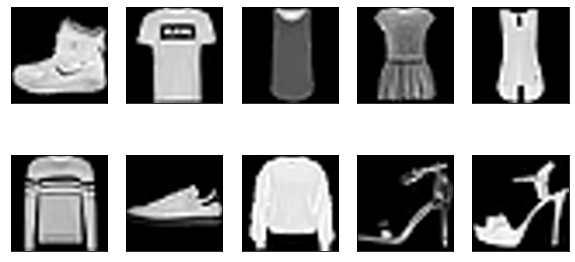

In [0]:
(xf_train, yf_train), (xf_test, yf_test) = fashion_mnist.load_data()
print("Shape of the data : ", xf_train.shape , xf_test.shape)
print("plot 10 sample of data")
show_image(xf_train)

In [0]:
# preprocessing the data
# regularize the data
xf_train = xf_train.astype(np.float32) / 255.
xf_test = xf_test.astype(np.float32) / 255.

# reshape the data for  cnn
xf_train_cnn = xf_train.reshape(len(xf_train),28,28,1)
xf_test_cnn = xf_test.reshape(len(xf_test),28,28,1)

# convert data to categorical data
# k =  number of categories
NUM_CLASSES = 10
yf_train_categorical = to_categorical(yf_train, num_classes = NUM_CLASSES)
yf_test_categorical = to_categorical(yf_test, num_classes = NUM_CLASSES)



### Implement ResNet module on the mnist fashion dataset

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
input_shape = xf_train_cnn.shape[1:]

# Start model definition.
num_filters_in = 16
inputs = Input(shape=input_shape)
x = resnet_layer(inputs=inputs, num_filters= 16, conv_first=True)

# Instantiate the stack of residual units
for stage in range(3):

    activation = 'relu'
    batch_normalization = True
    if stage == 0:
      num_filters_out = num_filters_in * 4
      activation = None
      batch_normalization = False
    else:
      num_filters_out = num_filters_in * 2


    # bottleneck residual unit
    y = resnet_layer(inputs=x,
        num_filters=num_filters_in,
        kernel_size=1,
        activation=activation,
        batch_normalization=batch_normalization,
        conv_first=False)

    y = resnet_layer(inputs=y,
        num_filters=num_filters_in,
        conv_first=False)

    y = resnet_layer(inputs=y,
        num_filters=num_filters_out,
        kernel_size=1,
        conv_first=False)

    # linear projection residual shortcut link
    x = resnet_layer(inputs=x,
        num_filters=num_filters_out,
        kernel_size=1,
        activation=None,
        batch_normalization=False)
    
    x = tensorflow.keras.layers.add([x, y])

    num_filters_in = num_filters_out

# Add classifier on top.
#BN-ReLU before Pooling
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
y = Flatten()(x)

outputs = Dense(NUM_CLASSES,activation='softmax',kernel_initializer='he_normal')(y)
model_res = Model(inputs=inputs, outputs=outputs)


In [0]:
model_res.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history_model_res = model_res.fit(xf_train_cnn, yf_train_categorical, epochs=5,verbose = 1, validation_data=(xf_test_cnn,yf_test_categorical))


Epoch 1/5
1875/1875 [==============================] - 31s 16ms/step - loss: 0.9467 - accuracy: 0.8577 - val_loss: 0.4900 - val_accuracy: 0.8894
Epoch 2/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3985 - accuracy: 0.9124 - val_loss: 0.3733 - val_accuracy: 0.9143
Epoch 3/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.3162 - accuracy: 0.9260 - val_loss: 0.3712 - val_accuracy: 0.9062
Epoch 4/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2678 - accuracy: 0.9361 - val_loss: 0.3263 - val_accuracy: 0.9115
Epoch 5/5
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2298 - accuracy: 0.9460 - val_loss: 0.3191 - val_accuracy: 0.9104


### Implement Inception Module on the mnist fashion dataset

In [0]:
input_img = Input(shape = (28, 28, 1))

tower_1 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
tower_1 = Conv2D(32, (3,3), padding='same', activation='relu')(tower_1)
tower_2 = Conv2D(32, (1,1), padding='same', activation='relu')(input_img)
tower_2 = Conv2D(32, (5,5), padding='same', activation='relu')(tower_2)
tower_3 = MaxPooling2D((3,3), strides=(1,1), padding='same')(input_img)
tower_3 = Conv2D(32, (1,1), padding='same', activation='relu')(tower_3)

In [0]:
output = tensorflow.keras.layers.concatenate([tower_1, tower_2, tower_3], axis = 3)
output = Flatten()(output)
out = Dense(NUM_CLASSES, activation='softmax')(output)
model_incep = Model(inputs = input_img, outputs = out)
model_incep.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#model_incep.summary()
history_model_incep = model_incep.fit(xf_train_cnn, yf_train_categorical, epochs=5, validation_data=(xf_test_cnn,yf_test_categorical))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 165us/sample - loss: 0.3797 - accuracy: 0.8669 - val_loss: 0.3198 - val_accuracy: 0.8878
Epoch 2/5
60000/60000 [==============================] - 9s 153us/sample - loss: 0.2544 - accuracy: 0.9077 - val_loss: 0.2899 - val_accuracy: 0.8980
Epoch 3/5
60000/60000 [==============================] - 9s 156us/sample - loss: 0.2021 - accuracy: 0.9257 - val_loss: 0.2823 - val_accuracy: 0.9062
Epoch 4/5
60000/60000 [==============================] - 9s 154us/sample - loss: 0.1649 - accuracy: 0.9405 - val_loss: 0.2976 - val_accuracy: 0.9030
Epoch 5/5
60000/60000 [==============================] - 9s 157us/sample - loss: 0.1348 - accuracy: 0.9508 - val_loss: 0.3322 - val_accuracy: 0.9032


### Implement CNN on the mnist fashion dataset

In [0]:
model_cnn = Sequential()
model_cnn.add(keras_Conv2D(filters= 32, kernel_size=(5,5), input_shape=(28,28,1), padding='same', activation='relu'))
model_cnn.add(keras_MaxPooling2D())
model_cnn.add(keras_Conv2D(filters= 64, kernel_size=(5,5), padding='same', activation='relu'))
model_cnn.add(keras_MaxPooling2D())
model_cnn.add(keras_Flatten())
model_cnn.add(keras_Dense(1024, activation='relu'))
model_cnn.add(keras_Dense(10,activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics =['accuracy'])
#model_cnn.summary()
history_model_cnn = model_cnn.fit(xf_train_cnn, yf_train_categorical, epochs=5, verbose = 1, validation_data=(xf_test_cnn,yf_test_categorical))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 10s 160us/step - loss: 0.3770 - accuracy: 0.8622 - val_loss: 0.2846 - val_accuracy: 0.8983
Epoch 2/5
60000/60000 [==============================] - 9s 155us/step - loss: 0.2486 - accuracy: 0.9075 - val_loss: 0.2666 - val_accuracy: 0.9049
Epoch 3/5
60000/60000 [==============================] - 9s 158us/step - loss: 0.2038 - accuracy: 0.9243 - val_loss: 0.2504 - val_accuracy: 0.9049
Epoch 4/5
60000/60000 [==============================] - 9s 156us/step - loss: 0.1702 - accuracy: 0.9369 - val_loss: 0.2426 - val_accuracy: 0.9133
Epoch 5/5
60000/60000 [==============================] - 9s 157us/step - loss: 0.1405 - accuracy: 0.9468 - val_loss: 0.2614 - val_accuracy: 0.9144


### Compare The Results from different Modules

Accuracy and loss of ResNet Module


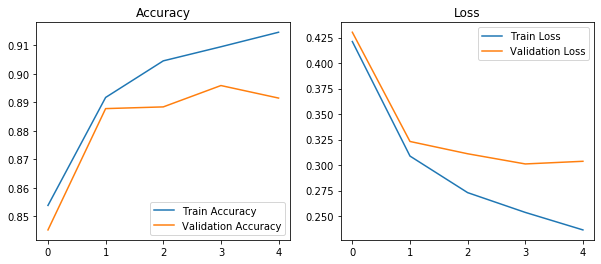

Accuracy and loss of Inception Module


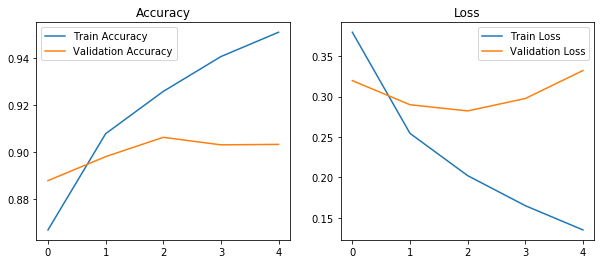

Accuracy and loss of CNN


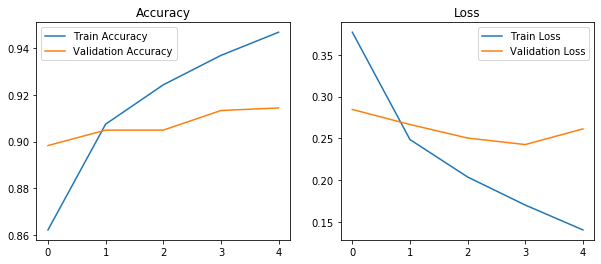

In [0]:
#Check the accuracy of the ResNet
print("Accuracy and loss of ResNet Module")
plot_accuracy(history_model_res)

#Check the accuracy of Inception
print("Accuracy and loss of Inception Module")
plot_accuracy(history_model_incep)

#Check the accuracy of CNN
print("Accuracy and loss of CNN")
plot_accuracy(history_model_cnn)